In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


## An easy problem

<Axes: >

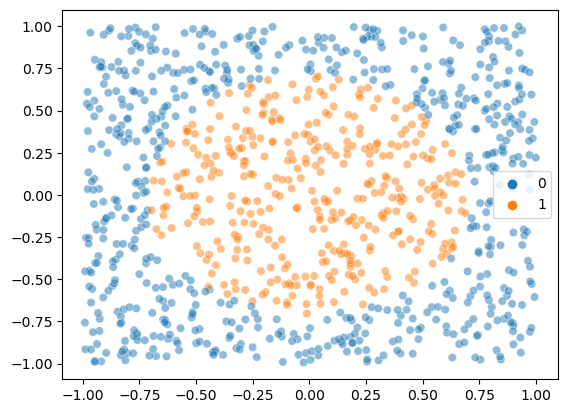

In [8]:
# Generate data
sample_size = 1000
np.random.seed(42)
x1 = np.random.uniform(-1, 1, sample_size)
x2 = np.random.uniform(-1, 1, sample_size)
ground_truth = (x1**2 + x2**2) < 0.5
y = ground_truth.astype(int)

# Plot the raw data
sns.scatterplot(x=x1, y=x2, hue=y, alpha=0.5)

In [4]:

# Construct a PyTorch model
class ClassifierNN(nn.Module):
    def __init__(self):
        super(ClassifierNN, self).__init__()
        self.layer1 = nn.Linear(2, 64)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.ReLU()
        self.layer5 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

model = ClassifierNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch: 1, Loss: 0.7264253497123718


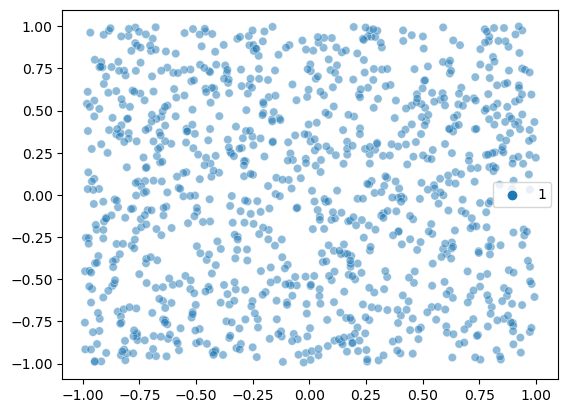

Epoch: 10, Loss: 0.4950855076313019


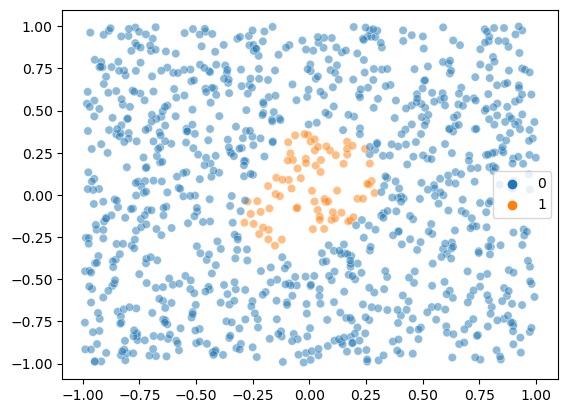

Epoch: 20, Loss: 0.24253599345684052


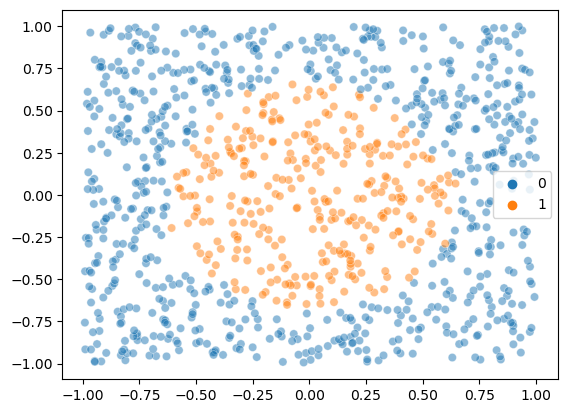

Epoch: 30, Loss: 0.08629138022661209


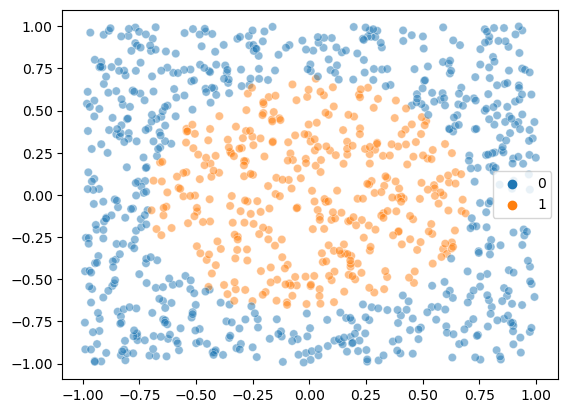

Epoch: 40, Loss: 0.04262809455394745


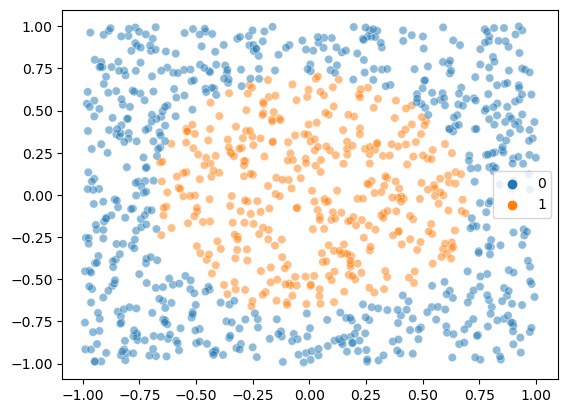

Epoch: 50, Loss: 0.02818020060658455


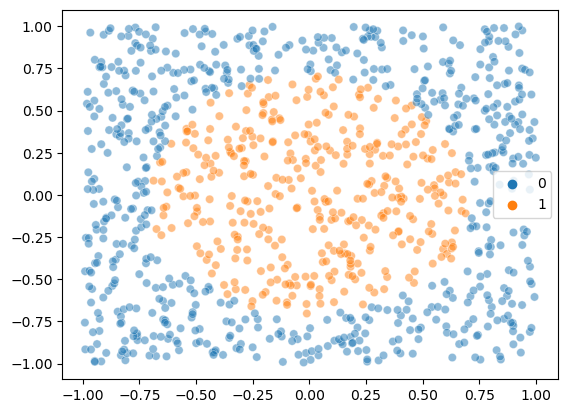

In [5]:

# Prepare data for training
x_tensor = torch.tensor(np.column_stack((x1, x2)), dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Training
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(x_tensor)
    loss = criterion(predictions, y_tensor) # criterion takes in predictons that are logits (so linear predictions, untransformed to probabilities)
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
        _, y_pred = torch.max(predictions, 1)
        sns.scatterplot(x=x1, y=x2, hue=y_pred.numpy(), alpha=0.5)
        plt.show()

## A harder problem

In [9]:
# Generate data
sample_size = int(5e3)
np.random.seed(42)
x1 = np.random.uniform(-1, 1, sample_size)
x2 = np.random.uniform(-1, 1, sample_size)

# Generate 10 classes with non-linear decision boundaries
y = np.zeros(sample_size, dtype=int)
angle = np.linspace(0, 2 * np.pi, 10, endpoint=False)
radius = np.linspace(0.5, 1, 10)
for i in range(10):
    y[((x1 - radius[i] * np.cos(angle[i])) ** 2 + (x2 - radius[i] * np.sin(angle[i])) ** 2 < 0.1)] = i



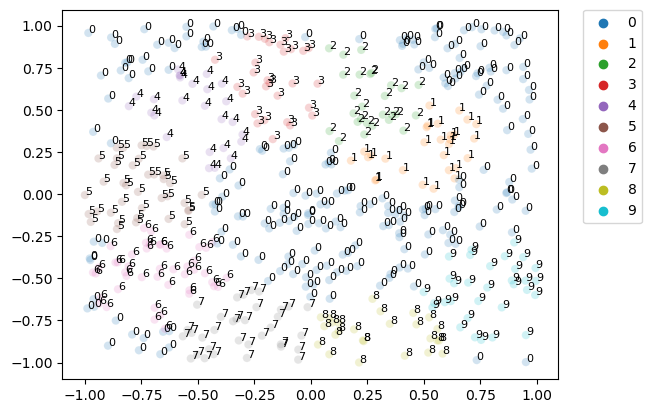

In [10]:
# Plot the raw data (sample of 500)
idx = np.random.choice(sample_size, 500, replace=False)
sns.scatterplot(x=x1[idx], y=x2[idx], hue=y[idx], palette='tab10', legend='full', alpha=0.2)

# Label each data point with its ground truth label
for i in range(len(idx)):
    plt.text(x1[idx[i]], x2[idx[i]], y[idx[i]], fontsize=8)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [16]:
class ClassifierNN(nn.Module):
    def __init__(self):
        super(ClassifierNN, self).__init__()
        self.layer1 = nn.Sequential( # layer 1 has two things, linear and activation, chained together with nn.Sequential()
            nn.Linear(2, 64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(64, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

In [17]:
# Convert data to tensors
x_data = torch.tensor(np.column_stack((x1, x2)), dtype=torch.float32)
y_data = torch.tensor(y, dtype=torch.long)

# Define dataset and dataloader
dataset = TensorDataset(x_data, y_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True) # DataLoader abstracting all of the details of computing random batch


Epoch: 1, Loss: 1.195668339729309


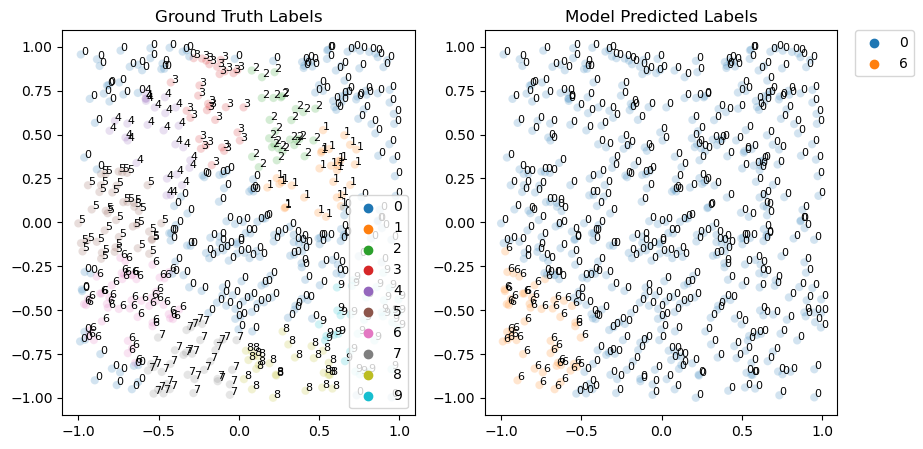

Epoch: 2, Loss: 0.900811493396759


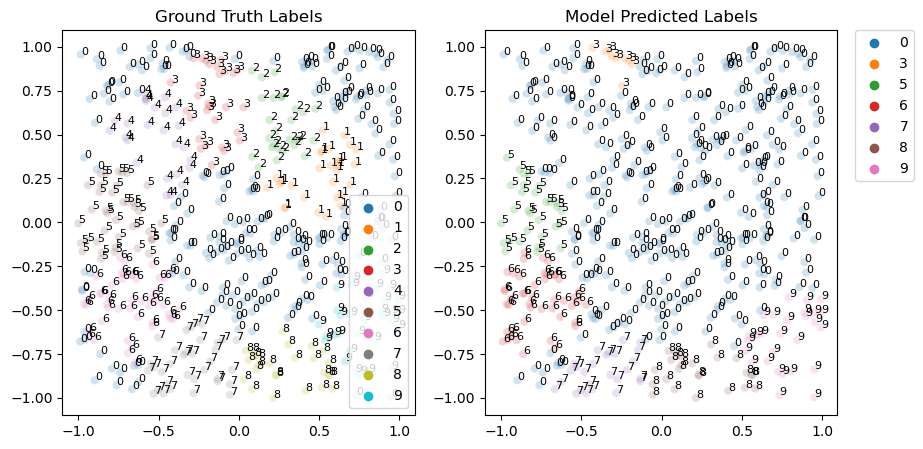

Epoch: 3, Loss: 0.41141676902770996


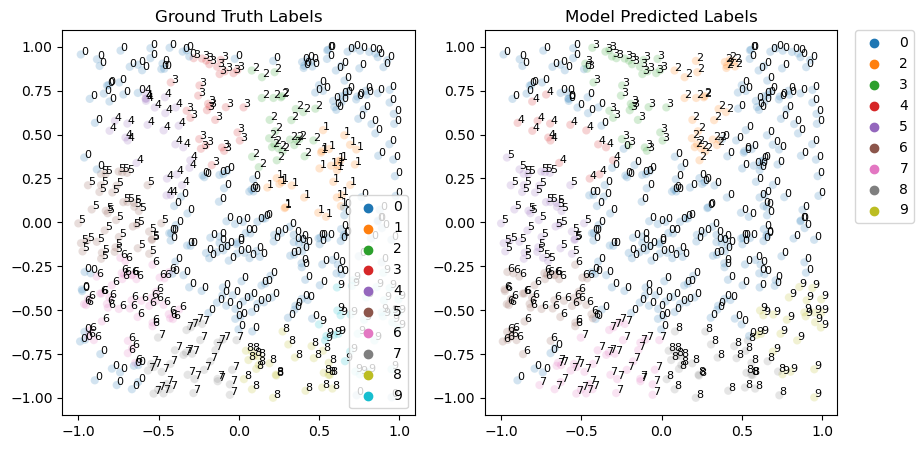

Epoch: 4, Loss: 0.8560265302658081


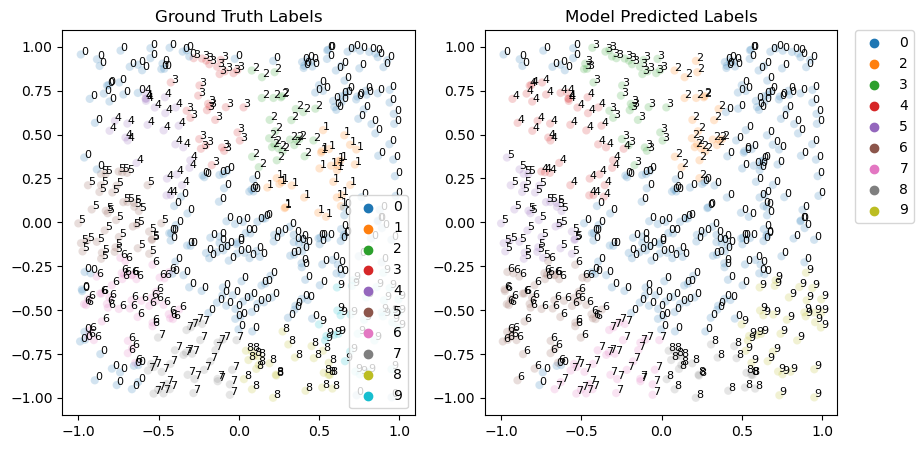

Epoch: 5, Loss: 0.42751938104629517


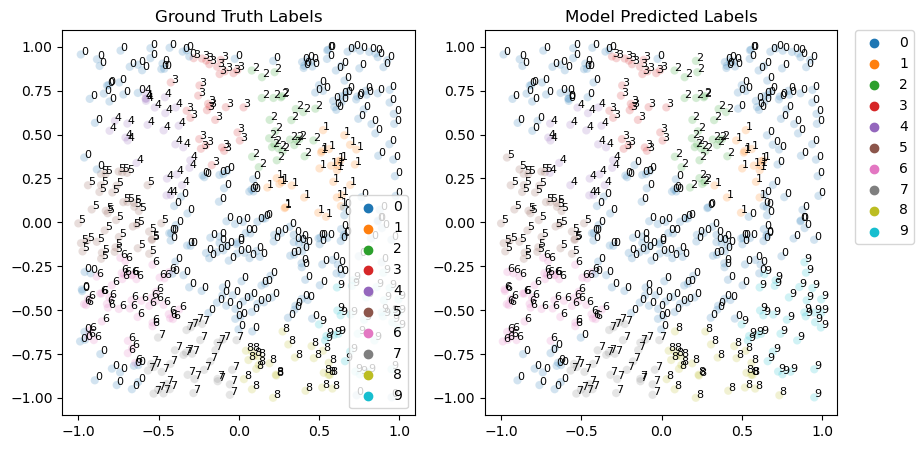

In [18]:
model = ClassifierNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 5
for epoch in range(epochs):
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
    with torch.no_grad():
        full_pred = model(x_data)
        _, y_pred = torch.max(full_pred, 1)
        labels = y_data.numpy()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.scatterplot(x=x1[idx], y=x2[idx], hue=labels[idx], palette='tab10', legend='full', alpha=0.2, ax=ax1)
        for i in range(len(idx)):
            ax1.text(x1[idx[i]], x2[idx[i]], labels[idx[i]], fontsize=8)
        ax1.set_title("Ground Truth Labels")
        sns.scatterplot(x=x1[idx], y=x2[idx], hue=y_pred.numpy()[idx], palette='tab10', legend='full', alpha=0.2, ax=ax2)
        for i in range(len(idx)):
            ax2.text(x1[idx[i]], x2[idx[i]], y_pred.numpy()[idx][i], fontsize=8)
        ax2.set_title("Model Predicted Labels")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()